In [64]:
# Following tutorial https://github.com/h2oai/h2o-tutorials/blob/master/h2o-world-2017/automl/Python/automl_regression_powerplant_output.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:

# Needed to install Java JRE https://www.java.com/en/download/win10.jsp 
import h2o 
from h2o.automl import H2OAutoML
h2o.init()

### Load data

In [49]:
# Setting 'parse_dates' in this case parses both dates and times
train_data = pd.read_csv('weather1_education_train.csv', parse_dates = ['timestamp'])
val_data = pd.read_csv('weather1_education_test.csv', parse_dates = ['timestamp'])

In [18]:
train_data.describe()

,Unnamed: 0,area,electricity,TemperatureC,month,year,date,hour,weekday,month_1,...,hour_23,wkday_0,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,PSU_PrimClass,PSU_UnivClass
count,437850.000000,437850.000000,437850.000000,437850.000000,437850.000000,437850.000000,437850.000000,437850.000000,437850.000000,437850.000000,...,437850.000000,437850.000000,437850.000000,437850.000000,437850.000000,437850.000000,437850.000000,437850.000000,437850.00,437850.00
mean,218924.500000,4564.680000,22.092696,9.470367,6.526664,2014.915039,15.718054,11.498915,2.991093,0.084846,...,0.041567,0.145255,0.142515,0.142515,0.142400,0.142515,0.142515,0.142286,0.98,0.02
std,126396.552019,3947.970853,33.351830,107.059247,3.447534,0.278823,8.796056,6.920784,2.003234,0.278653,...,0.199597,0.352358,0.349578,0.349578,0.349461,0.349578,0.349578,0.349344,0.14,0.14
min,0.000000,811.000000,0.004138,-9999.000000,1.000000,2014.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00
25%,109462.250000,2132.000000,3.900000,7.000000,4.000000,2015.000000,8.000000,6.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00,0.00
50%,218924.500000,2829.500000,7.100000,11.000000,7.000000,2015.000000,16.000000,11.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00,0.00
75%,328386.750000,6382.000000,27.200000,14.000000,10.000000,2015.000000,23.000000,17.000000,5.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00,0.00
max,437849.000000,14868.000000,298.699990,27.000000,12.000000,2015.000000,31.000000,23.000000,6.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.00


In [ ]:
# TODO - Val data is missing one categorical column
train_data.columns.difference(val_data.columns)

In [50]:
# Remove specific building type since one less column in one csv file
# Also drop year and timestamp, and 'Unamed: 0' index
train_data = train_data.drop(columns=['PSU_PrimClass', 'PSU_UnivClass', 'year', 'Unnamed: 0'])
val_data = val_data.drop(columns = ['PSU_PrimClass', 'year', 'Unnamed: 0'])

In [22]:
# train_data.columns  # lists all col names
# train_data.describe()  # summarize col value ranges
train_data.dtypes.head(10)  # see dtypes

area                    float64
building_name          category
electricity             float64
primary_space_usage    category
TemperatureC            float64
month                     int64
date                      int64
hour                      int64
weekday                   int64
month_1                   int64
dtype: object

- Dataframe is already in 'melted' / longer format

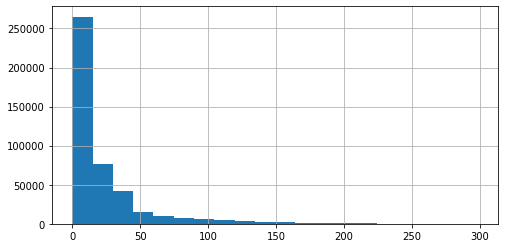

In [23]:
train_data['electricity'].hist(bins = 20, figsize = (8, 4))

### Fit a model

In [53]:
# Using crude train/val split, not walk-forward cross-val
# In h2o, if using all other cols for x, don't have to explicitly specify
y = "electricity"

# Must be formatted as h2o frames http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html
train =  h2o.H2OFrame(train_data.drop(columns =['timestamp']))
test = h2o.H2OFrame(val_data.drop(columns = ['timestamp']))


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [35]:
# Running for 60 s only fit one model (GLM), 3 min fit 3 (GLM, GBM, and Stacked Ensemble)
aml =  H2OAutoML(max_runtime_secs = 30, seed = 1, project_name = "energy_use_68_buildings")
aml.train(y = y, training_frame = train, leaderboard_frame = test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [37]:
aml.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20190806_022440,155.226,12.459,155.226,6.52095,nan
GBM_1_AutoML_20190806_022440,193.013,13.8929,193.013,8.41746,0.87359
GLM_grid_1_AutoML_20190806_022440_model_1,464.933,21.5623,464.933,17.1709,1.46573
GLM_grid_1_AutoML_20190806_023440_model_1,466.94,21.6088,466.94,17.2157,1.46783
GLM_grid_1_AutoML_20190806_022235_model_1,466.94,21.6088,466.94,17.2157,1.46783


In [42]:
# Inspect the leader model
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190806_022440

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 183.95576725158153
RMSE: 13.563029427512923
MAE: 6.912526132465449
RMSLE: NaN
R^2: 0.8346230128743413
Mean Residual Deviance: 183.95576725158153
Null degrees of freedom: 437849
Residual degrees of freedom: 437847
Null deviance: 487038941.09464395
Residual deviance: 80545032.69110498
AIC: 3525826.8252291773

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 193.3193597810863
RMSE: 13.90393324858424
MAE: 7.205117069982083
RMSLE: NaN
R^2: 0.8262051048938628
Mean Residual Deviance: 193.3193597810863
Null degrees of freedom: 437849
Residual degrees of freedom: 437847
Null deviance: 487040479.5474188
Residual deviance: 84644881.68014863
AIC: 3547565.2904434917


In [32]:
# make predictions using leader model
pred = aml.predict(test)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████| 100%


C:\Users\dmmma\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset column 'building_name' has levels not trained on: [PrimClass_Jacob, PrimClass_Jacquelyn, PrimClass_Jaden, PrimClass_Janie, PrimClass_Janis, PrimClass_Jasmine, PrimClass_Jayda, PrimClass_Jean, PrimClass_Jeff, PrimClass_Jeffery, PrimClass_Jermaine, PrimClass_Jesse, PrimClass_Jill, PrimClass_Jim, PrimClass_Joel, PrimClass_Johnathon, PrimClass_Johnnie, PrimClass_Jose, PrimClass_Judith]
  warnings.warn(w)


predict
15.7949
15.8012
15.8107
15.8224
15.8727
15.9869
25.4705
32.729
47.1742
52.7304


<function matplotlib.pyplot.show(*args, **kw)>

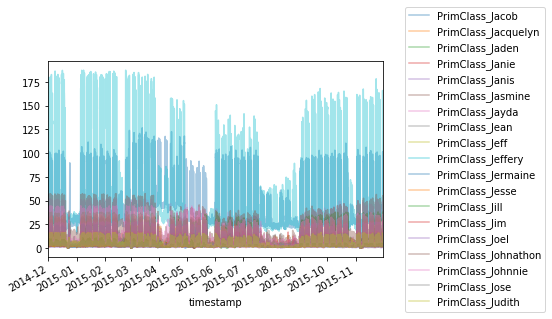

In [67]:

val_data.groupby('building_name')['electricity'].plot(alpha = 0.4);
plt.legend(loc= 'center right', bbox_to_anchor=(1.5, 0.5));
plt.show